In [1]:
import os
import requests

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/project/svd-kernels')
from src.optimizers import SVDAdam
from src.callbacks import OrthogonalityTracker, ConditioningTracker
from src.layers import SVDDense

In [3]:
plt.style.use('dark_background')

# Benchmarking using UCI datasets

Benchmarking singular value decomposed kernels using UCI datasets. <br>
Comparing regular MLPs versus MLP with SVD kernels. <br>
* UCI ... dataset
* UCI ... dataset

In [4]:
uci_directory = "https://archive.ics.uci.edu/ml/machine-learning-databases"

## Adult Data

In [5]:
data_name = 'adult'

### Data loading

In [6]:
# Get information about dataset
information = requests.get(os.path.join(uci_directory, data_name, data_name + '.names'))
# print(information.content.decode('utf-8'))

In [7]:
# Columns extracted from information (manual)
# names =  ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs' ,'restecg', 'thalach', 'exang','oldpeak','slope','ca','thal', 'num']
names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 
         'race', 'sex', 'capital-gain', 'captial-loss', 'hours-per-week', 'native-country', '50K']
# Read data
df = pd.read_csv(os.path.join(uci_directory, data_name, data_name + '.data'), encoding = 'latin', names=names, index_col=False, na_values='?')
# drop nan's
df = df.dropna()
# Get categorical features (5 is maximal number of discrete values --> taken from information)
categorical_columns = [col for col in df if np.unique(df[col]).size < 50]
# Get numerical features
numerical_columns = [col for col in df if col not in categorical_columns]
# Convert to correct dtype
df[numerical_columns] = df[numerical_columns].astype(float)
# Show data header
df.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,captial-loss,hours-per-week,native-country,50K
0,39.0,State-gov,77516.0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Visualization

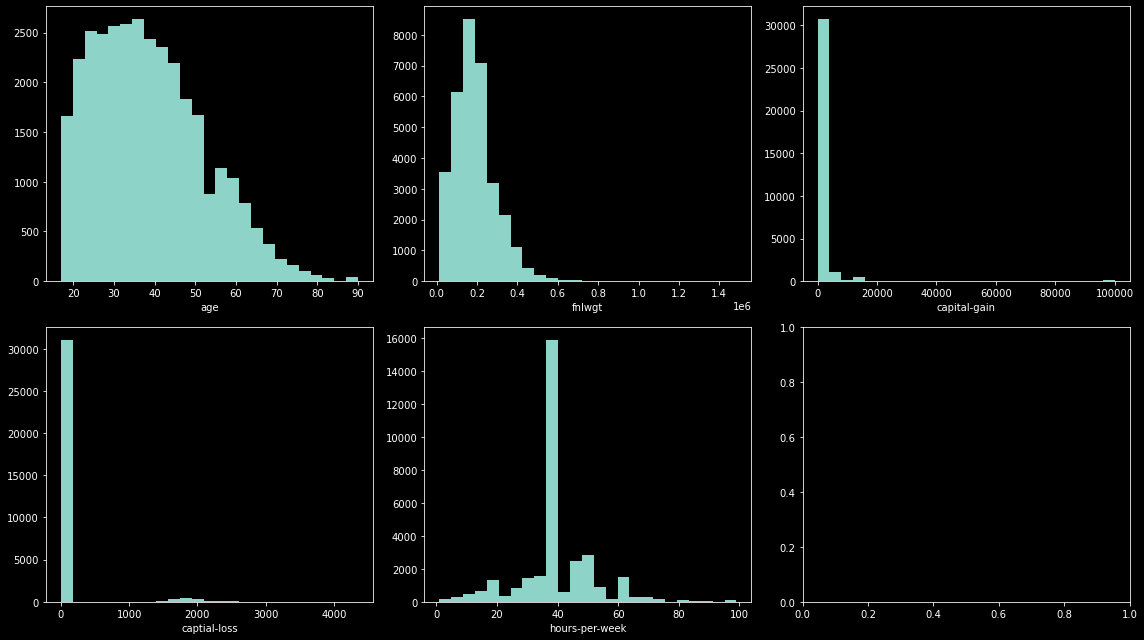

In [8]:
rows = int(np.sqrt(len(numerical_columns)))
cols = int(np.ceil(len(numerical_columns)/rows))
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
for ax, col in zip(axes.reshape(-1)[:len(numerical_columns)], numerical_columns):
    ax.hist(df[col].values, bins=25)
    ax.set_xlabel(col)
plt.tight_layout()
plt.show()

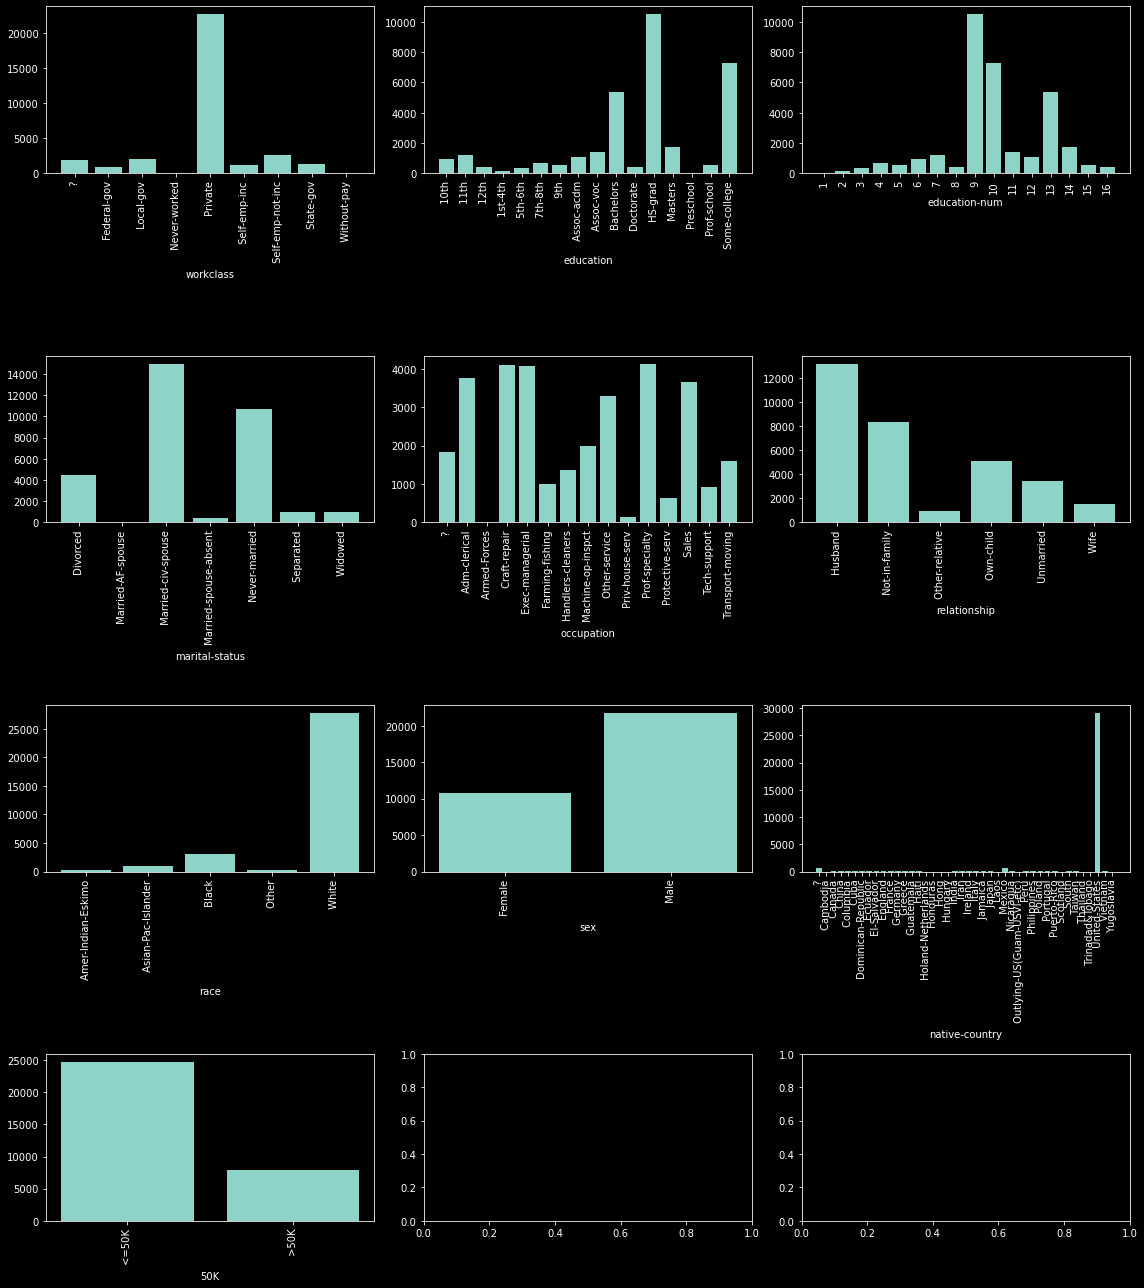

In [9]:
cols = int(np.sqrt(len(categorical_columns)))
cols = 3
rows = int(np.ceil(len(categorical_columns)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(16, 18))
for ax, col in zip(axes.reshape(-1)[:len(categorical_columns)], categorical_columns):
    values, counts = np.unique(df[col].values, return_counts=True)
    ax.bar(values, counts)
    ax.set_xticks(values)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel(col)
plt.tight_layout()
plt.show()

### Preprocessing

In [10]:
from sklearn.preprocessing import quantile_transform

In [11]:
# Encode categorical variables
df = pd.get_dummies(df, columns=categorical_columns)
# Normalize features
df[numerical_columns] = quantile_transform(df[numerical_columns], n_quantiles=25, output_distribution='normal')
# Show data header
df.head(1)

,age,fnlwgt,capital-gain,captial-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,50K_ <=50K,50K_ >50K
0,0.104633,-1.171915,1.468964,-5.199338,-0.104633,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


### Data pipeline

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Get target columns
target_columns = [col for col in df if '50K' in col]
x, y = df.drop(target_columns, axis=1).values, df[target_columns].values[:, 0]
# Split data
split = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split, shuffle=True)

In [14]:
batch_size = 32
buffer_size = batch_size * 128
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
for x, y in dataset.take(1):
    print(x.shape, y.shape)

(32, 123) (32,)


### Model

In [15]:
# Parameters for model architecture
units = [128, 128]
ranks = [96, 96]
activation = 'elu'

In [16]:
def build_model(units, ranks=None):
    # Empty layers list
    layers = [None] * len(units)
    # Make layers
    if ranks is None:
        for idx, unit in enumerate(units):
                    layers[idx] = tf.keras.layers.Dense(unit, activation)  
    else:
        assert len(ranks) == len(units)
        for idx, (unit, rank) in enumerate(zip(units, ranks)):
            layers[idx] = SVDDense(unit, rank, activation)
    # Make input layer
    inputs = tf.keras.Input(shape=x.shape[1:])
    hidden = inputs
    # hidden layers
    for layer in layers:
        hidden = layer(hidden)
    # Projectionl layer
    outputs = tf.keras.layers.Dense(1, 'sigmoid')(hidden)
    # Make & compile model
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [17]:
# Number of epochs
epochs = 50
# Learning rates
learning_rate = 10e-5
nu = 10e-5
# acceleration parameters
beta = 0.9
gamma = 0.999

# Loss and accuracy
loss_fn = tf.keras.losses.BinaryCrossentropy()
accuracy_fn = tf.keras.metrics.BinaryAccuracy()

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy', mode='max', verbose=1, patience=3)

In [18]:
# Make model
model = build_model(units)
# SVD optimizer
optimizer = SVDAdam(model, learning_rate, nu, beta, gamma)
# Compile model
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Callbacks
callbacks = [early_stopping]
# Train model
history = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=0)

Epoch 00021: early stopping


In [19]:
# Make trackers
orthogonality_tracker = OrthogonalityTracker(on_batch=True)
conditioning_tracker = ConditioningTracker(on_batch=True)

In [20]:
# Make model
model = build_model(units, ranks)
# SVD optimizer
optimizer = SVDAdam(model, learning_rate, nu, beta, gamma, method='chi', k=None)
# Compile model
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Add trackers to callbacks
callbacks += [orthogonality_tracker, conditioning_tracker]
# Train model
history_ = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=0)

InvalidArgumentError:  Input is not invertible.
	 [[node svd_adam_1/MatrixInverse_3 (defined at /project/svd-kernels/src/optimizers/utils.py:75) ]] [Op:__inference_train_function_46843]

Errors may have originated from an input operation.
Input Source operations connected to node svd_adam_1/MatrixInverse_3:
 svd_adam_1/add_41 (defined at /project/svd-kernels/src/optimizers/utils.py:73)

Function call stack:
train_function


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16, 9))
for key, value in history.history.items():
    i = 0 if 'loss' in key else 1
    axes[i].plot(value, label=key)
for key, value in history_.history.items():
    i = 0 if 'loss' in key else 1
    axes[i].plot(value, label=key, linestyle='dotted')
plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16, 9))
for layer in model.layers:
    if 'svd' in layer.name:
        axes[0].plot(orthogonality_tracker.kappa[layer.name]['u'], label=layer.name)
        axes[1].plot(orthogonality_tracker.kappa[layer.name]['v'], label=layer.name)
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].legend()
axes[1].legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(16, 9))
for layer in model.layers:
    if 'svd' in layer.name:
        plt.plot(conditioning_tracker.kappa[layer.name], label=layer.name)
plt.yscale('log')
plt.legend()
plt.show()

### Multiple runs

In [24]:
n_iterations = 1

units_list = [8, 16, 32, 64, 128, 256]
iterations = []
for it in range(n_iterations):
    results = []
    for units in units_list:
        inputs = tf.keras.Input(shape=x.shape[1:])
        hidden = inputs
        for layer in range(n_layers):
            hidden = tf.keras.layers.Dense(units, activation)(hidden)
        outputs = tf.keras.layers.Dense(1, 'sigmoid')(hidden)

        # Learning rate
        learning_rate = 10e-5
        # Make loss function, accuracy function & optimizer
        loss_fn = tf.keras.losses.BinaryCrossentropy()
        accuracy_fn = tf.keras.metrics.BinaryAccuracy()
        optimizer = tf.keras.optimizers.SGD(learning_rate, momentum=0.9)
        # Make & compile model
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
        # Number of epochs
        epochs = 100
        # Simple early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', mode='max', verbose=1, patience=3)
        # Fit model
        history = model.fit(dataset, validation_data=(x_test, y_test), epochs=epochs, callbacks=[early_stopping], verbose=0)
        # Accuracies
        train_accuracy = accuracy_fn(model.predict(x_train), y_train)
        test_accuracy = accuracy_fn(model.predict(x_test), y_test)
        results.append((train_accuracy.numpy(), test_accuracy.numpy()))
    iterations.append(results)

NameError: name 'n_layers' is not defined

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16, 9))
for key, value in history.history.items():
    i = 0 if 'loss' in key else 1
    axes[i].plot(value, label=key)
plt.legend()
plt.show()

In [ ]:
t = np.array(iterations)

In [ ]:
plt.figure(figsize=(12, 9))
a, b = np.mean(t[..., 0], axis=0), np.mean(t[..., 1], axis=0)
a_, b_ = np.std(t[..., 0], axis=0), np.std(t[..., 1], axis=0)
plt.bar(x=np.arange(len(units_list)) + 0.125, width=0.25, height=a-0.8, yerr=a_, label='Train', ecolor='grey')
plt.bar(x=np.arange(len(units_list)) - 0.125, width=0.25, height=b-0.8, yerr=b_, label='Test', ecolor='grey')
plt.legend()
plt.show()

In [ ]:
from typing import *
from src.models.utils import unpack
from src.optimizers.utils import update_svd

class SVDAdam(tf.keras.optimizers.Optimizer):
    """Adam Optimizer function for SVD based architectures with keras optimizer compatibility"""

    def __init__(self, model: tf.keras.Model, learning_rate: float = 10e-4, nu: Optional[float] = None,
                 beta: float = 0.9, gamma: float = 0.999, name: Optional[str] = None):
        """Initialize optimizer

        Parameters
        ----------
        model: tf.keras.Model
            Model accompanied by optimizer. Needed for architecture unpacking
        learning_rate: float
            Learning rate for optimizer
            (Default is 10e-4)
        nu: float
            Learning rate for cayley transform. If None it is set equal to learning rate
            (Default is None)
        beta: float
            Momentum parameter
            (Default is 0.9)
        gamma: float
            Velocity parameter
            (default is 0.999)
        name: Optional[str]
            Name of optimizer
            (default is None)
        """
        super(SVDAdam, self).__init__(name=name)
        # Set parameters
        self.learning_rate = learning_rate
        self.nu = nu if nu is not None else learning_rate
        self.beta = beta
        self.gamma = gamma
        self.model = model
        self.epsilon = 10e-8
        # Unpack model
        self.names = [var.name for name, layer in unpack([self.model]) for var in layer.variables]
        # Indices of svd variables
        self.slices = [
            slice(idx, idx + 3) for idx, name in enumerate(self.names) if ('svd' in name) & ('U' in name)]

    def _create_slots(self, var_list: List[tf.Variable]):
        """Create slots for optimizer

        Parameters
        ----------
        var_list: List[tf.Variable]
            List of variables for which slots are made
        """
        # Create slots for momentum and velocity
        for variable in var_list:
            self.add_slot(variable, "momentum")
            self.add_slot(variable, "velocity")

    def _apply_adam(self, grad, var):
        """Apply modified adam.

        Notes
        -----
        This application implements both adaptive learning rate and momentum into the gradient calculation.
        Subsequently this reduces the gradient update to a regular SGD update.

        Parameters
        ----------
        grad: tf.Tensor
            Gradient tensor
        var: tf.Variable
            Variable

        Returns
        -------
        Updated gradient corresponding to Adam application.
        """
        # Get slots
        momentum = self.get_slot(var, "momentum")
        velocity = self.get_slot(var, "velocity")
        # Calculate updated variables
        momentum.assign(self.beta * momentum + tf.multiply(1. - self.beta, grad))
        velocity.assign(self.gamma * velocity + tf.multiply(1. - self.gamma, tf.math.pow(grad, 2)))
        # Apply iteration scaling
        momentum_ = momentum / (1. - tf.math.pow(self.beta, tf.cast(self.iterations + 1, momentum.dtype)))
        velocity_ = velocity / (1. - tf.math.pow(self.gamma, tf.cast(self.iterations + 1, velocity.dtype)))
        # Return adam scaled gradients
        return tf.sqrt(velocity_ + self.epsilon) ** (-1) * momentum_

    def _transform_gradients(self, grads_and_vars: Iterable[Any]):
        """Transform gradients before application.

        Notes
        -----
        This function is called before application in 'apply_gradients'.

        Parameters
        ----------
        grads_and_vars: Iterable
            Gradients and variables

        Returns
        -------
            Gradients and variables with updated gradients
        """
        print(self.slices)
        # Get list of all variable indices
        indices = list(range(len(list(grads_and_vars))))
        # Calculate SVD variables per layer
        for idx in self.slices:
            # Get gradients and variables for components
            (du, ds, dv), (u, s, v) = zip(*grads_and_vars[idx])
            # Modify gradients for adam
            du, ds, dv = self._apply_adam(du, u), self._apply_adam(ds, s), self._apply_adam(dv, v)
            # Update svd layer with modified gradients
            du, ds, dv = update_svd(u, s, v, du, ds, dv, self.nu, self.learning_rate, self.nu, self.epsilon)
            # Re-add updated gradients to grads & vars
            grads_and_vars[idx] = [(du, u), (ds, s), (dv, v)]
            # Delete svd indices
            del indices[idx]

        # Iterate over normal weights
        for idx, (grad, var) in enumerate(grads_and_vars):
            if idx in indices:
                # Apply adam
                grad = self._apply_adam(grad, var)
                # Scale with learning rate
                grads_and_vars[idx] = (-self.learning_rate * grad, var)
        return grads_and_vars

    def _resource_apply_dense(self, grad: tf.Tensor, handle: tf.Variable, apply_state: dict):
        """Application of gradients for dense tensors.

        Notes
        -----
        This application function just does a addition of the gradient.

        Parameters
        ----------
        grad: tf.Tensor
            Gradient for application
        handle: tf.Variable
            Variable on which to apply gradient
        apply_state: dict
            State of application

        Returns
        -------
        Updated variable
        """
        return handle.assign_add(grad)

    def _resource_apply_sparse(self, grad, handle, indices, apply_state):
        """Application of gradients for sparse tensors.

        Notes
        -----
        This application function just does a addition of the gradient.

        Parameters
        ----------
        grad: tf.Tensor
            Gradient for application
        handle: tf.Variable
            Variable on which to apply gradient
        indices: tf.Tensor
            Indices of sparse tensor for which to apply gradients
        apply_state: dict
            State of application

        Returns
        -------
        Updated variable
        """
        return handle.assign_add(grad)

    def get_config(self):
        """Get configuration.

        Returns
        -------
        Serialized configuration
        """
        return super().get_config()